In [1]:
# # Roberto Guillermo Lavagnino Rodriguez
# 201803199
#  Proyecto final 


In [2]:
#nos sirve para dibujar los datos
import matplotlib.pyplot as plt
#framework para hacer las funciones del grafo
import tensorflow as tf
#Matetmaticos
import numpy as np
#tiempo
import time
import random
from datetime import timedelta
#operaciones matematicas
import math
#operciones de IO
import os
# para la lectura de los archivos
import pickle

#ANCHOR OPERACIONES DE LAS IMAGENES

In [3]:
#ANCHOR Filtros
def filtrarImagen(img, tam, estaEntrenando):    
    if estaEntrenando:
        # delimitamos la imgane usando el tensor flow
        img = tf.random_crop(img, size=[tam, tam, 3])
        # rotamos la imagen para la aumentar la eficiencia
        img = tf.image.random_flip_left_right(img)
        #Agregamos filtros aleatorios
        img = tf.image.random_hue(img, max_delta=0.05)
        img = tf.image.random_contrast(img, lower=0.3, upper=1.0)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_saturation(img, lower=0.0, upper=2.0)
        #obtenemos los pixeles que necesitamos
        img = tf.minimum(img, 1.0)
        img = tf.maximum(img, 0.0)
    
    else:
        #Solo lo cambiamos o cortamos
        img = tf.image.resize_image_with_crop_or_pad(img,
                                                       target_height=tam,
                                                       target_width=tam)
    
    return img
#* aplicamos los filtros a cada llamada
def aplicarFiltros(imagenes,tam,estaEntrenando):   
    imgTransformados = tf.map_fn(lambda img: filtrarImagen(img, tam,estaEntrenando), imagenes)
    return imgTransformados

#ANCHOR Pasar a vector
#* reajustamos imagenes para dividirlo en vectores
def reajustarImagenes(imagenes, tamaño):
   #Cambiamos las imagenes para que sean un arreglo de numpy
    inicio = imagenes.shape[0]
    #Inicializamos nueva vector con las imagenes
    nuevaImagen = np.zeros((inicio, tamaño, tamaño, 3))
    j = 0
    #por cada imagen
    for img in imagenes:
        #obtemos la capa de los colores
        rojo = img[0:tamaño*tamaño]/255
        verde = img[tamaño*tamaño:tamaño*tamaño*2]/255
        azul = img[tamaño*tamaño*2:tamaño*tamaño*3]/255
        #inicializamos la nueva matriz de cada imagenes
        resultado = np.zeros((32,32,3))
        for fila in range(0, tamaño): 
            for col in range(0, tamaño): 
                point = np.zeros(3)
                point[0] = rojo[fila*32+col]
                point[1] = verde[fila*32+col]
                point[2] = azul[fila*32+col]
                resultado[fila][col] = point
        nuevaImagen[j] = resultado
        j += 1
    return nuevaImagen


In [4]:
#ANCHOR Clases que vienen en el cifar 10
labelsOriginales = ['Avion',
    'Carro',
    'Pajaro',
    'Gato',
    'Venado',
    'Perro',
    'Sapo',
    'Caballo',
    'Barco',
    'Camion']


In [5]:
#ANCHOR dibujar imagenes
def dibujar(data, labels,archivos,img):
    X = np.asarray(data.T).astype("uint8") 
    labelPos = labelsOriginales[labels[img]]
    Y = np.zeros((10,10000))
    for i in range(10000):
        Y[labels[i],i] = 1
    plotear(X,Y,archivos,img,labelPos)

def plotear(X,Y,archivos,id,posLabel):
    rgb = X[:,id]
    img = rgb.reshape(3,32,32).transpose([1, 2, 0])
    plt.imshow(img) 
    print('Clase: ' + posLabel)
    print('Archivo: ' , archivos[id])
    #plt.title(archivos[id]+'-'+posLabel)


In [6]:
#ANCHOR matplotib
%matplotlib inline
import matplotlib.pyplot as plt


In [7]:
# *lee el archivo y devuelvo los dato
def deserializar(arch):
    with open(arch, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# *Produce un codigo convolucional de un mensaje.
def convEncoding(input):
    result = []
    for code in input:
        inner = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        inner[code] = 1.0
        result.append(inner)
    return result




In [8]:
# ANCHOR cargar archivo
direccionCifar = "cifar-10-batches-py/data_batch_"
direccionCifarPrueba = "cifar-10-batches-py/"

# * Funcion que carga los datos
def cargarArchivo():
    #Construimos un vector con los 5 archivos 
    archEntreno = [direccionCifar + str(i) for i in range(1, 6)]
    print('Archivos con datasets: ')
    print(archEntreno)
    archPrueba = direccionCifarPrueba + 'test_batch'
    #inicializmaos los datos que nos van a utilizar
    datosEntrena = deserializar(archEntreno[0])
    datosPrueba = deserializar(archPrueba)
    #Obtenemos los datos de la imagen de la columan data
    datosImagen = datosEntrena[b'data']
    datosArchivos = datosEntrena[b'filenames']
    datosImagenPrueba = datosPrueba[b'data']
    #Obtenemos los nombres de las clases
    labelEntrenamiento = datosEntrena[b'labels']
    labelPrueba = datosPrueba[b'labels']
    #obtenemso los datos de los siguientes archivos
    for _arch in archEntreno[1:5]:
        _data = deserializar(_arch)
        datosImagen = np.concatenate((datosImagen, _data[b'data']), axis=0)
        labelEntrenamiento += _data[b'labels']
        datosArchivos += _data[b'filenames']

    labelEntrenamiento = np.asarray(labelEntrenamiento)
    labelPrueba = np.asarray(labelPrueba)

    return datosImagen, datosImagenPrueba, labelEntrenamiento, labelPrueba, datosArchivos


Archivos con datasets: 
['cifar-10-batches-py/data_batch_1', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/data_batch_5']
a entrenar: (50000, 3072)
a probar: (10000, 3072)
Clase: Pajaro
Archivo:  b'cassowary_s_001372.png'


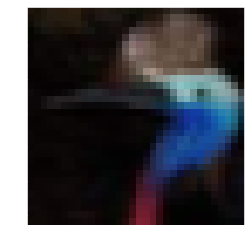

In [9]:
#ANCHOR Cargar los datos
imagenesEntrena, imagenesPrueba, _etiquetaEntrena, _etiquetaPrueba, nombreImagenes = cargarArchivo()
print("a entrenar:", imagenesEntrena.shape)
print("a probar:", imagenesPrueba.shape)
etiquetaEntrena = _etiquetaEntrena
dibujar(imagenesEntrena,etiquetaEntrena,nombreImagenes,random.randint(1,10000))


In [10]:
#ANCHOR Reajuste de imagenes
imagenesEntrenaReajustado = reajustarImagenes(imagenesEntrena, 32)
imagenesPruebaReajustado = reajustarImagenes(imagenesPrueba, 32)
print("Imagenes reajustadas:", imagenesEntrenaReajustado.shape,imagenesPruebaReajustado.shape)



Imagenes reajustadas: (50000, 32, 32, 3) (10000, 32, 32, 3)


In [11]:
#ANCHOR  variable para aprender
totalInteraciones = 300
tamañoLote = int(len(etiquetaEntrena)/totalInteraciones)
print(tamañoLote)


166


In [12]:
# Colocamos las 
etiquetaEntrena = convEncoding(_etiquetaEntrena)
etiquetaPrueba = convEncoding(_etiquetaPrueba)
etiquetaEntrena = np.asarray(etiquetaEntrena)
etiquetaPrueba = np.asarray(etiquetaPrueba)


#ANCHOR el mero mero CNN

In [13]:
#* nos devuelve la clase que cree que gato, perro avion
def adivinacion (x):
    claseAdivinada = tf.argmax(x, 1, name='claseAdivinada')
    return claseAdivinada

#* Calculamos la exactituda aqui
def calcularExactitud(x, y):
    adivinada = tf.argmax(x, 1, name='cAdivinada')
    verdadero = tf.argmax(y, 1, name='cVerdadera')
    #miramos la media
    exactitud = tf.reduce_mean(tf.cast(tf.equal(adivinada, verdadero), tf.float64))
    return exactitud

#* obtenemos media la entropia cruzada 
def calcularEntropia(x, y):
    # mide el error de probabilidad en tareas de clasificación 
    sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=x, name='entropia')
    cross_ent = tf.reduce_mean(sm_ce, name='mentropia')
    return cross_ent

#* Aplana a una matriz 2d
# @param x tensor input
# @param W filtro
def conv(x, W):
    # los strides [altura, anchuras, canales de entrada, canalis de salida]
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME")

#* Agrupamos
def maxpool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#* Lo Fraccionario
def fractional_maxpool(x):
    return tf.nn.fractional_max_pool(x, pooling_ratio=[1, 1.44, 1.44, 1])

def cnn(x):
    #convertimos el tensor a un numero
    x_image = tf.cast(x, tf.float32)
    #creamos las  las variables, formateadas
    filtro1 = tf.get_variable("filtro1", shape = [5,5,3,64])
    data1 = tf.get_variable("data1", shape = [64])
    #Aplanamos la imagen y le aplicamos la operacion relu
    resulConv1 = tf.nn.relu(tf.add(conv(x_image, filtro1), data1))
    #Agrupamos
    resul1 = maxpool(resulConv1)
    
    #2da capa
    filtro2 = tf.get_variable("filtro2", shape=[5,5,64, 64])
    data2 = tf.get_variable("data2", shape=[64])
    #Aplanamos el resultado anterior y le aplicamos la operacion relu
    resulConv2 = tf.nn.relu(tf.add(conv(resul1, filtro2), data2))
    #agrupamos
    resul2 = maxpool(resulConv2)
    #limpiamos la red nueronal
    resul2Limpio = tf.nn.dropout(resul2, 0.8)
    #cambiamos nuestro tensor
    resul2Reajustado = tf.reshape(resul2Limpio, [-1, 6*6*64])
    filtro3 = tf.get_variable('filtro3', shape=[6*6*64, 256])
    data3 = tf.get_variable('data3', shape=[256])
    resul3 = tf.nn.relu(tf.add(tf.matmul(resul2Reajustado, filtro3), data3))

    filtro4 = tf.get_variable("filtro4", shape=[256, 128])
    data4 = tf.get_variable("data4", shape=[128])
    resul4 = tf.nn.relu(tf.add(tf.matmul(resul3, filtro4), data4))

    filtro5 = tf.get_variable('filtro5', shape=[128, 10])
    data5 = tf.get_variable('data5', shape=[10])
    #nuestra adivinacion con normalizacion
    logits = tf.add(tf.matmul(resul4, filtro5), data5, name='cnn')
    return(logits)


In [14]:
def dibujarImagenesProcesadas(listadoImagenes, clasesReales, clasesAdivinadas=None, w=32, estaReajustado=True):
    #creamos el fondo
    fig, axes = plt.subplots(2, 5)
    #Ajustamos el fondo
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    #Si la imagen esta reajustdda, 
    if estaReajustado:
        reshaped_images = reajustarImagenes(listadoImagenes, w)
    else:
        reshaped_images = listadoImagenes
    for i, ax in enumerate(axes.flat):
        # dibujamos y lo suabizamos
        ax.imshow(reshaped_images[i],interpolation='spline16')
        #Obtenemos el nombre real de la clases    
        indice = np.where(clasesReales[i] == 1)
        print(indice[0])
        claseVerdadera = labelsOriginales[indice[0][0]]

        if clasesAdivinadas is None:
            # si no pudo aprender que solo muestre la clase
            xlabel = "Clase: {0}".format(claseVerdadera)
        else:
            # Poner los datos
            PredName = labelsOriginales[clasesAdivinadas[i]]
            xlabel ="Clase: {0}\n Adivino: {1}".format(claseVerdadera, PredName)
        #Ponemos la clase
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
def dibujarClaseAdivina(listaAdivinada, listaVerdadera):
    count_incorrect = 0
    image_index = []
    true_classes = []
    pred_classes = []
    for i in range(len(listaVerdadera)):
        if count_incorrect < 10:
            if (listaVerdadera[i] != listaAdivinada[i]).all():
                count_incorrect += 1
                image_index.append(i)
                true_classes.append(listaVerdadera[i])
                pred_classes.append(listaAdivinada[i])
    images =  imagenesPruebaReajustado[image_index]
    dibujarImagenesProcesadas(images,clasesReales=true_classes, clasesAdivinadas= pred_classes,  w=32, estaReajustado= False)   



Empezamos a aprender
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Inicio del ciclo 0
Interaccion # 0
Interaccion # 100
Interaccion # 200
Aprendido 0.11977911646586331
Termino prueba.....
Prueba Porcentaje aprendido 0.15000000000000002
[3]
[6]
[6]
[1]
[6]
[5]
[7]
[8]
[5]
[7]
Inicio del ciclo 1
Interaccion # 0
Interaccion # 100
Interaccion # 200
Aprendido 0.17491967871485947
Termino prueba.....
Prueba Porcentaje aprendido 0.219
[3]
[8]
[6]
[1]
[6]
[3]
[0]
[5]
[7]
[9]
Inicio del ciclo 2
Interaccion # 0
Interaccion # 100
Interaccion # 200
Aprendido 0.21026104417670693
Termino prueba.....
Prueba Porcentaje aprendido 0.24000000000000005
[3]
[8]
[0]
[6]
[6]
[6]
[3]
[1]
[0]
[9]
Inicio del ciclo 3
Interaccion # 0
Interaccion # 100
Interac

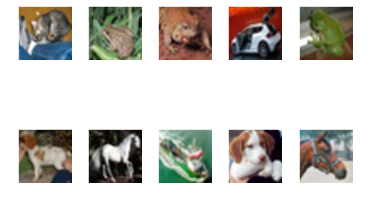

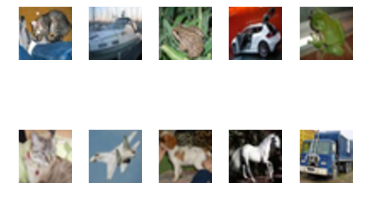

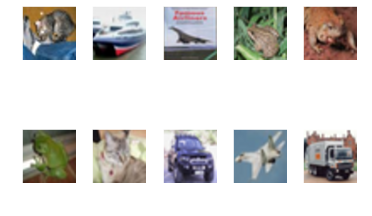

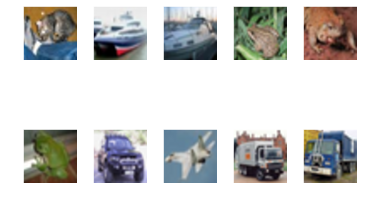

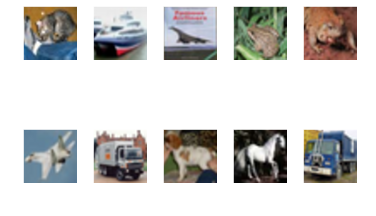

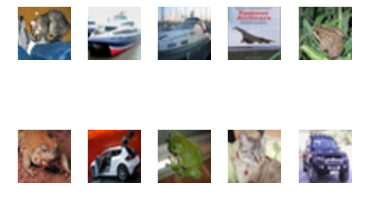

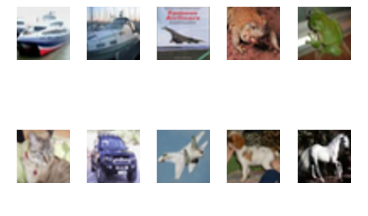

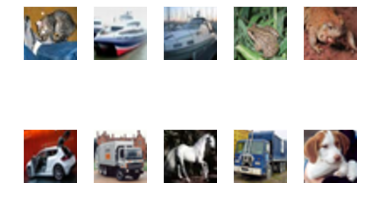

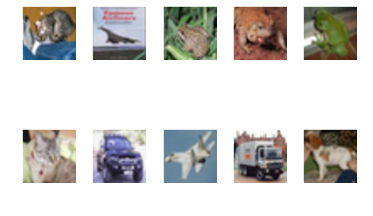

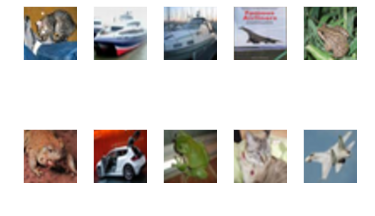

In [15]:
# ANCHOR Grafo
#Inicializamos el grafo
tf.reset_default_graph()
print('Empezamos a aprender')
with tf.Graph().as_default():
    
    start_time = time.time()
    #Colocamos los placeholders
    x = tf.placeholder(tf.float32, [None, 32,32,3], name="x")
    y = tf.placeholder(tf.float32, [None, 10], name = "y")
    #ponemos la bandera que esta entrnenado
    estaEntrenando = True
    #Preprocesando
    with tf.variable_scope("preprocesado", reuse=not estaEntrenando):
        dataFiltroAplicados = aplicarFiltros(x,24,estaEntrenando) #tensor with distorted images
    with tf.variable_scope("modelo", reuse=not estaEntrenando):
        logits = cnn(dataFiltroAplicados)
    with tf.variable_scope("perdida",reuse=not estaEntrenando):
        perdida = calcularEntropia(x=logits, y=y)
    with tf.variable_scope("exactitud", reuse=not estaEntrenando):
        accuracy = calcularExactitud(logits, y)
    with tf.variable_scope("adivinacion", reuse=not estaEntrenando):
        pred_class = adivinacion(logits)
    #Optimizamos los resultado con la perdida
    with tf.variable_scope("estaEntrenando"):
        train_step = tf.train.AdamOptimizer(0.00001).minimize(perdida)
    #Guardamos las variables
    saver = tf.train.Saver()
    #Optimizamos los recursos con esta configuracion
    config = tf.ConfigProto()
    #configuramos que no haya limite en el consumo
    config.gpu_options.allow_growth = True
    #Creamos la sesion
    sess = tf.Session(config=config)
    #Inicializamos las variables
    sess.run(tf.global_variables_initializer())
        
    # control de aprendizaje y fallos
    perdidaEntrenamiento = []
    porcentajeAprendido = []
    pruebaPerdido = []
    pruebaExactitud = []
    
    with tf.device("/device:GPU:0"):        
        for index in range(0, 10):
            listadoPerdida = []
            listadoAprendido = []
            print('Inicio del ciclo {:g}'.format(index))
            for i in range(totalInteraciones):
                estaEntrenando = True
                imagenes = imagenesEntrenaReajustado[i * tamañoLote: (i + 1) * tamañoLote]
                etiquetas = etiquetaEntrena[i * tamañoLote: (i + 1) * tamañoLote]
                #corremos el grafo
                _ , porcentajePerdida, porcentajeExactitud = sess.run((train_step,perdida,accuracy), feed_dict={x:imagenes, y:etiquetas})
                #guardamos un resitro de perdidas
                listadoPerdida.append(porcentajePerdida)
                listadoAprendido.append(porcentajeExactitud)
                
                if i%100==0: #para mostrar cuantas interacinnes
                    print("Interaccion # {:g}".format(i))
                    
            elt = sum(listadoPerdida)/ float(len(listadoPerdida))
            perdidaEntrenamiento.append(elt)
            eat =  sum(listadoAprendido)/ float(len(listadoAprendido))
            porcentajeAprendido.append(eat)
            
            print("Aprendido", eat)
            #Guardamos las variable de sesion
            if index%100 == 0:
                saver.save(sess, 'modelo', global_step=index)
            
            #ANCHOR Prueba de modelo
            exitoPrueba = []
            falloPrueba = []
            adivinacionClase =[]
            for i in range(0, 10):
                estaEntrenando =False
                loss_val, acc_val, pred_val = sess.run((perdida,accuracy, pred_class),
                          feed_dict={x: imagenesPruebaReajustado[i*100:i*100+100], 
                                     y: etiquetaPrueba[i*100:i*100+100]})
                falloPrueba.append(loss_val)
                exitoPrueba.append(acc_val)
                adivinacionClase.append(pred_val)
            #calculamos    
            eltp = sum(falloPrueba)/ float(len(falloPrueba))
            pruebaPerdido.append(eltp)
            eatp =  sum(exitoPrueba)/ float(len(exitoPrueba))
            pruebaExactitud.append(eatp)
            print('Termino prueba.....')
            print("Prueba Porcentaje aprendido", eatp)
            dibujarClaseAdivina(adivinacionClase[index], etiquetaPrueba[0:100])


